# Warum ist die Banane krumm?

In [1]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2
import palettable
from astropy.cosmology import Planck15

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.profiles import MassProfileNFW, MassProfileSIE
from simulation.population_sim import SubhaloPopulation
from simulation import prior
from simulation.lensing_sim import LensingSim


## Grid

In [2]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Load likelihood contours for comparison

In [22]:
filename = "calibrated_alices_full_sgd1e2_grid"
setting = "full"
llr = np.mean(np.load("../data/results/llr_{}.npy".format(filename)), axis=-1)
llr = -2. * llr
llr -= np.min(llr)

In [23]:
n_for_lines = [100, 20, 5]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", ":"]
clabels = ["100", "20", "5"]

## Calculate quantities

In [7]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [8]:
def _mag_to_flux(mag, mag_zp):
    """
    Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`
    """
    return 10 ** (-0.4 * (mag - mag_zp))

In [9]:
def simulate_deflection(ps, theta_E, z_l, theta_x_0=0., theta_y_0=0., theta_s_e = 0.2, z_s = 1.5, mag_s = 23.0, mag_zero=25.5, mag_iso=22.5, n_xy=64, pixel_size=0.1, q=1, exposure=1610.0):
    S_tot = _mag_to_flux(mag_s, mag_zero)
    f_iso = _mag_to_flux(mag_iso, mag_zero)
    
    coordinate_limit = pixel_size * n_xy / 2.0

    # Set host properties. Host assumed to be at the center of the image.
    hst_param_dict = {"profile": "SIE", "theta_x_0": 0.0, "theta_y_0": 0.0, "theta_E": theta_E, "q": q}

    lens_list = [hst_param_dict]

    # Set subhalo properties
    for i_sub, (m, theta_x, theta_y) in enumerate(zip(ps.m_sample, ps.theta_x_sample, ps.theta_y_sample)):
        c = MassProfileNFW.c_200_SCP(m)
        r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
        sub_param_dict = {"profile": "NFW", "theta_x_0": theta_x, "theta_y_0": theta_y, "M_200": m, "r_s": r_s, "rho_s": rho_s}
        lens_list.append(sub_param_dict)

    # Set source properties
    src_param_dict = {"profile": "Sersic", "theta_x_0": theta_x_0, "theta_y_0": theta_y_0, "S_tot": S_tot, "theta_e": theta_s_e, "n_srsc": 1}

    # Set observation and global properties
    observation_dict = {
        "n_x": n_xy,
        "n_y": n_xy,
        "theta_x_lims": (-coordinate_limit, coordinate_limit),
        "theta_y_lims": (-coordinate_limit, coordinate_limit),
        "exposure": exposure,
        "f_iso": f_iso,
    }

    global_dict = {"z_s": z_s, "z_l": z_l}

    # Inititalize lensing class and produce lensed image
    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    
    _, _, (x_d, y_d), r_pixels = lsi.lensed_image(return_deflection_maps=True)
    
    x_d = x_d.flatten()
    y_d = y_d.flatten()
    cut = (r_pixels - theta_E)**2 < 0.2**2
    
    overall_mean_deflection = np.mean((x_d**2. + y_d**2)**0.5)
    einstein_ring_mean_deflection = np.mean((x_d**2. + y_d**2)**0.5 * cut) / np.mean(cut)
    
    return overall_mean_deflection, einstein_ring_mean_deflection


In [55]:
def calculate_summaries(f_sub, beta, n=100, calculate_deflection=False):
    if np.abs((beta + 2.)) < 1.e-3:
        beta = -2.001
    
    mhosts, total_msubs, avg_msubs, nsubs, m23s  = [], [], [], [], []
    deflections, einstein_ring_deflections = [], []
    
    for i in range(n):
        m_min_calib=1e6 * M_s
        m_max_sub_div_M_hst_calib=0.01
        m_200_min_sub=1e7 * M_s
        m_200_max_sub_div_M_hst=0.01
        roi_size=2.
        M_200_sigma_v_scatter = True
        
        z_l = 2.0
        while z_l > 1.0:
            z_l = 10 ** np.random.normal(-0.25, 0.25)
        sigma_v = np.random.normal(225, 50)
        
        theta_s_e = 0.2
        z_s = 1.5
        mag_s = 23.0
        
        D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc
        D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
        D_ls = Planck15.angular_diameter_distance_z1z2(z1=z_l, z2=z_s).value * Mpc
        
        M_200_hst = M_200_sigma_v(sigma_v * Kmps, scatter=M_200_sigma_v_scatter)
        c_200_hst = MassProfileNFW.c_200_SCP(M_200_hst)
        r_s_hst, rho_s_hst = MassProfileNFW.get_r_s_rho_s_NFW(M_200_hst, c_200_hst)
        theta_E = MassProfileSIE.theta_E(sigma_v * Kmps, D_ls, D_s)
        
        f_sub_realiz = 2.0
        while f_sub_realiz > 1.0:
            ps = SubhaloPopulation(
                f_sub=f_sub,
                beta=beta,
                M_hst=M_200_hst,
                c_hst=c_200_hst,
                m_min=m_200_min_sub,
                m_max=m_200_max_sub_div_M_hst * M_200_hst,
                m_min_calib=m_min_calib,
                m_max_calib=m_max_sub_div_M_hst_calib * M_200_hst,
                theta_s=r_s_hst / D_l,
                theta_roi=roi_size * theta_E,
                theta_E=theta_E,
                params_eval=[],
                calculate_joint_score=False,
            )
            f_sub_realiz = ps.f_sub_realiz
            
        deflection = 0.
        einstein_ring_deflection = 0.
        if calculate_deflection:
            deflection, einstein_ring_deflection = simulate_deflection(ps=ps, theta_E=theta_E, z_l=z_l)
        else:
            sigma_cr = 1. / (4. * np.pi * GN) * D_s / (D_ls * D_l)
            for i_sub, (m, theta_x, theta_y) in enumerate(zip(ps.m_sample, ps.theta_x_sample, ps.theta_y_sample)):
                c = MassProfileNFW.c_200_SCP(m)
                r_s, rho_s = MassProfileNFW.get_r_s_rho_s_NFW(m, c)
                deflection += 4. * r_s**2 * rho_s / sigma_cr / D_l * radtoasc
            
        mhosts.append(ps.M_hst_roi/M_s)
        total_msubs.append(np.sum(ps.m_sample/M_s))
        avg_msubs.append(np.nanmean(ps.m_sample/M_s))
        nsubs.append(ps.n_sub_roi)
        m23s.append(np.sum((ps.m_sample/M_s)**(2./3.)))
        deflections.append(deflection)
        einstein_ring_deflections.append(einstein_ring_deflection)
    
    mean_total_msub = np.nanmean(total_msubs)
    mean_fsub = np.nanmean(np.asarray(total_msubs) / np.asarray(mhosts))
    mean_msub = np.nanmean(avg_msubs)
    mean_nsub = np.nanmean(nsubs)
    mean_m23 = np.nanmean(m23s)
    mean_deflection = np.nanmean(deflections)
    mean_einstein_ring_deflection = np.nanmean(einstein_ring_deflections)
    
    return mean_total_msub, mean_fsub, mean_msub, mean_nsub, mean_m23, mean_deflection, mean_einstein_ring_deflection


## Run

In [77]:
mean_total_msubs, mean_fsubs, mean_msubs, mean_nsubs, mean_m23s, mean_approx_deflections = [], [], [], [], [], []

for i, theta in enumerate(theta_grid):
    if (i+1) % 50 == 0:
        print("{} / {}".format(i+1, 625))
    mean_total_msub, mean_fsub, mean_msub, mean_nsub, mean_m23, mean_approx_deflection, _ = calculate_summaries(
        theta[0], theta[1], n=4000
    )
    mean_total_msubs.append(mean_total_msub)
    mean_fsubs.append(mean_fsub)
    mean_msubs.append(mean_msub)
    mean_nsubs.append(mean_nsub)
    mean_m23s.append(mean_m23)
    mean_approx_deflections.append(mean_approx_deflection)
    

/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


50 / 625
100 / 625
150 / 625
200 / 625
250 / 625
300 / 625
350 / 625
400 / 625
450 / 625
500 / 625
550 / 625
600 / 625


In [82]:
mean_approx_deflections = np.array(mean_approx_deflections)
np.save("mean_approx_deflections.npy", mean_approx_deflections)

In [69]:
#mean_deflections = []
#mean_einstein_ring_deflections = []

#for i, theta in enumerate(theta_grid):
#    if (i+1) % 50 == 0:
#        print("{} / {}".format(i+1, 625))
#    _,_,_,_,_, mean_deflection, mean_einstein_ring_deflection = calculate_summaries(
#        theta[0], theta[1], n=5, calculate_deflection=True
#    )
#    mean_deflections.append(mean_deflection)
#    mean_einstein_ring_deflections.append(mean_einstein_ring_deflection)
    

## Paper plot of just the deflection

In [79]:
paper_settings.setup()

In [80]:
dmin, dmax = 0., 0.9
dthresholds = [0.05,0.1, 0.2, 0.4]

data = np.array(mean_approx_deflections)
data_clip = np.clip(data, dmin, dmax)

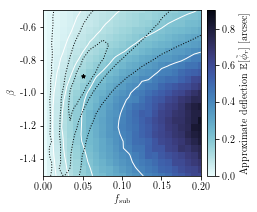

In [81]:
fig, (ax, cax) = paper_settings.figure(
    cbar=True,
)

plt.sca(ax)
pcm = ax.imshow(
    data_clip.reshape((resolution, resolution)),
    extent=(alpha_edges[0],alpha_edges[-1],beta_edges[0], beta_edges[-1]),
    cmap=paper_settings.CMAP1,
    origin="lower",
    aspect="auto",
    norm=matplotlib.colors.Normalize(vmin=dmin, vmax=dmax),
)
# pcm = ax.pcolormesh(
#     alpha_edges,
#     beta_edges,
#     data_clip.reshape((resolution, resolution)),
#     norm=matplotlib.colors.Normalize(vmin=dmin, vmax=dmax),
#     cmap=paper_settings.CMAP1
# )
cs = ax.contour(
    0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
    0.5 * (beta_edges[1:] + beta_edges[:-1]),
    data.reshape((resolution, resolution)),
    dthresholds,
    colors="white",
    linewidths=1.,
    linestyles="-",
)
cs = ax.contour(
    0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
    0.5 * (beta_edges[1:] + beta_edges[:-1]),
    llr.reshape((resolution, resolution)),
    thresholds,
    colors="black",
    linewidths=1.,
    linestyles=":",
)
plt.scatter(0.05, -1.9, s=15., color='black', marker='*')

plt.xlabel(r'$f_{\mathrm{sub}}$')
plt.ylabel(r'$\beta$')
plt.xlim(0.,0.2)
plt.ylim(-2.5,-1.5) 
plt.xticks([0.,0.05,0.1,0.15,0.2])
plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
 
cbar = fig.colorbar(pcm,cax=cax,)
cbar.set_label(r'Approximate deflection $\mathbb{E}[\tilde{\phi}_r]$ [arcsec]')
    
plt.savefig("../figures/warum_ist_die_banane_krumm.pdf", dpi=300)


## Plot all summaries

In [ ]:
fig = plt.figure(figsize=(12,10))

for i, (data, label) in enumerate(zip(
    [mean_total_msubs, mean_msubs, mean_nsubs, mean_m23s],
    ["Mean total subhalo mass", "Mean individual subhalo mass", "Mean number of subhalos", "Mean $m^{2/3}$", "Mean deflection sum", "Mean deflection sum along Einstein radius"]
)):
    ax = plt.subplot(2,2,i+1)
    data = np.asarray(data).reshape(25,25)
    
    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        data,
        #norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    cs = ax.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        llr.reshape((resolution, resolution)),
        thresholds,
        colors="white",
        linewidths=1.,
        linestyles=contour_ls,
    )
    
    plt.clabel(cs, fmt={thresholds[i] : clabels[i] for i in range(len(thresholds))},
          manual=[(0.04,-2.07), (0.09,-1.8), (0.14,-1.7), (0.17,-1.95)])
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(label)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/other/warum_ist_die_banane_krumm.pdf")
